In [137]:
import os
import sys
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit
from pyspark.sql.functions import desc
from pyspark.sql.functions import col
from pyspark.sql.functions import size
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.core.interactiveshell import InteractiveShell
import matplotlib
from pylab import *
InteractiveShell.ast_node_interactivity = "all" # This helps auto print out the items without explixitly using 'print'

# Initialize a spark session.

conf = pyspark.SparkConf().setMaster("local[*]")
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("BigData Project - Exploratory Analysis") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = '../data/endomondoHR_proper.json'
#filename_metadata = './data/endomondoMeta.json'
# Load the main data set into pyspark data frame 
df = spark.read.json(filename_data, mode="DROPMALFORMED")

# Load meta data file into pyspark data frame as well
#df_meta = spark.read.json(filename_metadata, mode="DROPMALFORMED")
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


In [69]:
print('Columns & datatypes:')
DataFrame(df.dtypes, columns =['Column Name','Data type'])

Columns & datatypes:


,Column Name,Data type
0,altitude,array<double>
1,gender,string
2,heart_rate,array<bigint>
3,id,bigint
4,latitude,array<double>
5,longitude,array<double>
6,speed,array<double>
7,sport,string
8,timestamp,array<bigint>
9,url,string


In [12]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

print('\nFisrt 2 data rows:')
df.limit(2).toPandas()

Data frame describe (string and numeric columns only):


,summary,gender,id,sport,url,userId
0,count,167783,167783,167783,167783,167783
1,mean,None,3.614780933983598E8,None,None,4565819.273555724
2,stddev,None,1.571586171633681E8,None,None,3906676.555400663
3,min,female,257936,aerobics,https://www.endomondo.com/users/10014612/worko...,69
4,max,unknown,674007977,yoga,https://www.endomondo.com/users/9991401/workou...,15481421



Fisrt 2 data rows:


,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915
1,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,"[60.173247596248984, 60.17320962622762, 60.172...","[24.649855233728886, 24.65015547350049, 24.650...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...",bike,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915


In [81]:
print('Summarize on genders:')
gender_user_count = df.select('gender','userId').distinct().groupBy('gender').count().toPandas()
gender_activities_count = df.groupBy('gender').count().toPandas()
gender_user_activity_count = gender_user_count.join(gender_activities_count.set_index('gender'), on='gender'
                                                    , how='inner', lsuffix='_gu')
gender_user_activity_count.columns = ['Gender', '# of users', 'Activities (workouts) count']
gender_user_activity_count

Summarize on genders:


,Gender,# of users,Activities (workouts) count
0,unknown,15,1185
1,female,101,9881
2,male,943,156717


In [167]:
rdd=df.rdd
def avgHeartRate(row):
    if row['heart_rate']!='':
        ht=np.mean(row['heart_rate'])
        return Row(id=int(row['id']), avgHT=float(ht), gender=str(row['gender']),sport=str(row['sport']),userId=row['userId'])
rddaHR=rdd.map(avgHeartRate)
rddaHR.take(3)
df1=spark.createDataFrame(rddaHR)
DataFrame(df1.dtypes, columns =['Column Name','Data type'])

[Row(avgHT=152.65, gender='male', id=396826535, sport='bike', userId=10921915),
 Row(avgHT=147.71, gender='male', id=392337038, sport='bike', userId=10921915),
 Row(avgHT=140.554, gender='male', id=389643739, sport='bike', userId=10921915)]

,Column Name,Data type
0,avgHT,double
1,gender,string
2,id,bigint
3,sport,string
4,userId,bigint


In [168]:
df2=df1.groupBy(['gender','sport']).avg('avgHT')
df2.createOrReplaceTempView("table1")
df2M=spark.sql("SELECT * from table1 where gender='male'")
df2M.toPandas()
df2FM=spark.sql("SELECT * from table1 where gender='female'")
df2FM.toPandas()

,gender,sport,avg(avgHT)
0,male,martial arts,109.044000
1,male,sailing,163.934000
2,male,fitness walking,104.853535
3,male,windsurfing,132.492000
4,male,treadmill walking,186.644000
5,male,aerobics,141.228800
6,male,snowshoeing,127.474727
7,male,elliptical,131.963400
8,male,gymnastics,104.550400
9,male,roller skiing,129.653974


,gender,sport,avg(avgHT)
0,female,mountain bike,142.596029
1,female,run,151.428408
2,female,fitness walking,127.391624
3,female,cross-country skiing,135.610060
4,female,orienteering,155.238818
5,female,kayaking,92.156000
6,female,hiking,114.032450
7,female,bike (transport),131.209013
8,female,snowshoeing,121.362000
9,female,horseback riding,142.704000


In [171]:
df2A=df2M.join(df2FM, 'sport','outer')
df2A.toPandas()

,sport,gender,maleAvg,gender,femaleAvg
0,weight training,male,107.399738,female,129.021000
1,windsurfing,male,132.492000,None,NaN
2,gymnastics,male,104.550400,female,153.598000
3,mountain bike,male,135.334108,female,142.596029
4,pilates,male,96.287333,None,NaN
5,cross-country skiing,male,138.137305,female,135.610060
6,hiking,male,110.213909,female,114.032450
7,kayaking,male,123.132933,female,92.156000
8,downhill skiing,male,85.424542,None,NaN
9,kite surfing,male,152.434000,None,NaN


In [172]:
df2M=df2M.withColumnRenamed('avg(avgHT)','maleAvg')
df2FM=df2FM.withColumnRenamed('avg(avgHT)','femaleAvg')
df2AInner=df2M.join(df2FM, 'sport','inner')
df2AInner=df2AInner.withColumn('diffAvg',df2AInner.maleAvg-df2AInner.femaleAvg)
df2AInner.toPandas()

,sport,gender,maleAvg,gender,femaleAvg,diffAvg
0,weight training,male,107.399738,female,129.021000,-21.621262
1,gymnastics,male,104.550400,female,153.598000,-49.047600
2,mountain bike,male,135.334108,female,142.596029,-7.261921
3,cross-country skiing,male,138.137305,female,135.610060,2.527246
4,hiking,male,110.213909,female,114.032450,-3.818541
5,kayaking,male,123.132933,female,92.156000,30.976933
6,roller skiing,male,129.653974,female,139.967600,-10.313626
7,circuit training,male,118.425579,female,133.212308,-14.786729
8,fitness walking,male,104.853535,female,127.391624,-22.538089
9,orienteering,male,146.885183,female,155.238818,-8.353635


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

Text(0.5, 0, 'sport')

Text(0, 0.5, 'the difference of average heart rate between male and female')

<BarContainer object of 22 artists>

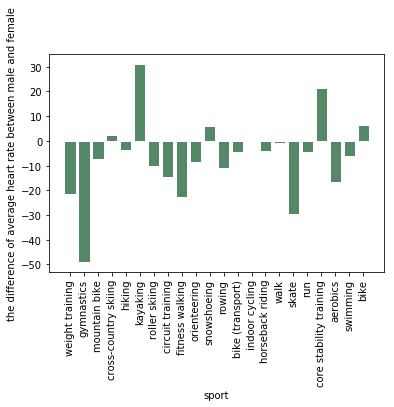

In [173]:
rddAInner=df2AInner.rdd
sportType=rddAInner.map(lambda row: row['sport']).collect()
diffAvg=rddAInner.map(lambda row: row['diffAvg']).collect()
plt.xticks(rotation=90)
plt.xlabel('sport')
plt.ylabel('the difference of average heart rate between male and female')
bar(sportType, diffAvg, facecolor='#558866', edgecolor='white')

Result: 1) For most sports, female have higher average heart rate than male;
        2) Gender and sport type play key roles in people's heart rate change

In [251]:
rdd1=df.rdd
def heartRate(row):
    if row['heart_rate']!='' and row['speed']!='' and row['altitude']!='':        
        verht=np.var(row['heart_rate'])
        versp=np.var(row['speed'])
        verat=np.var(row['altitude'])
        ht=np.mean(row['heart_rate'])
        return Row(id=int(row['id']), avgHT=float(ht), verht=float(verht), versp=float(versp), verat=float(verat), gender=str(row['gender']), sport=str(row['sport']),userId=row['userId'])
#             return Row(ratiohtsp=float(vecsp))
rddaHR1=rdd1.filter(lambda row: row['speed'] is not None).map(heartRate)
df3=spark.createDataFrame(rddaHR1)
df3.describe().toPandas()

,summary,avgHT,gender,id,sport,userId,verat,verht,versp
0,count,31673,31673,31673,31673,31673,31673,31673,31673
1,mean,140.3423847441038,None,4.093069950743851E8,None,5243788.332491396,1585.2863534988305,179.86626795087295,36.18060698609785
2,stddev,16.24100500119093,None,1.5311083842498413E8,None,4201234.897447884,14670.082987516083,140.3180894748648,41.328774946316
3,min,58.908,female,9406163,bike,2358,0.0,0.0,0.0
4,max,199.892,unknown,669263168,walk,15326644,1251233.13491504,1829.758384,1325.353987486656


In [275]:
df4=df3.groupBy(['gender','sport']).agg({'avgHT':'mean','verat':'mean', 'verht':'mean','versp':'mean'})
df4.createOrReplaceTempView("table2")
df4M=spark.sql("SELECT * from table2 where gender='male'")
df4M.toPandas()
df4FM=spark.sql("SELECT * from table2 where gender='female'")
df4FM.toPandas()

,gender,sport,avg(avgHT),avg(verht),avg(verat),avg(versp)
0,male,fitness walking,118.493333,199.846844,147.826950,7.254175
1,male,roller skiing,137.405368,154.648292,158.185923,13.123898
2,male,bike (transport),125.273064,158.289247,304.507780,37.323198
3,male,kayaking,129.525800,111.705816,9.853310,1.619603
4,male,run,148.805687,130.511010,506.629540,3.198004
5,male,bike,135.757144,211.594215,2445.574588,57.665407
6,male,orienteering,140.879455,182.066078,471.972767,3.606460
7,male,cross-country skiing,146.426417,127.203610,161.177512,18.439206
8,male,hiking,116.614000,252.963228,1417.403749,3.110315
9,male,skate,165.261000,90.029030,127.380871,34.764991


,gender,sport,avg(avgHT),avg(verht),avg(verat),avg(versp)
0,female,mountain bike,153.724857,120.014732,227.828683,44.715628
1,female,run,152.853398,124.127495,206.696366,2.806686
2,female,fitness walking,124.927619,140.925673,302.372164,2.692113
3,female,cross-country skiing,153.088000,139.856440,3784.293802,55.619569
4,female,bike (transport),132.068851,223.601117,269.705901,39.919631
5,female,bike,136.034379,225.872322,1646.439964,43.098350
6,female,indoor cycling,133.703619,258.900956,307.616298,152.736762
7,female,walk,95.845846,91.597803,87.851249,2.466000
8,female,core stability training,103.956500,51.652295,22.826941,0.510083
9,female,skate,157.271200,136.633385,61.014101,12.574078


In [276]:
df4M=df4M.withColumnRenamed('avg(avgHT)','maleAvgHT').withColumnRenamed('avg(verht)','maleVarht').withColumnRenamed('avg(verat)','maleVarat').withColumnRenamed('avg(versp)','maleVarsp')
df4FM=df4FM.withColumnRenamed('avg(avgHT)','femaleAvgHT').withColumnRenamed('avg(verht)','femaleVarht').withColumnRenamed('avg(verat)','femaleVarat').withColumnRenamed('avg(versp)','femaleVarsp')
df4AInner=df4M.join(df4FM, 'sport','inner')
df4AInner=df4AInner.withColumn('ratioMVarhtat',df4AInner.maleVarht/df4AInner.maleVarat).withColumn('ratioMVarhtsp',df4AInner.maleVarht/df4AInner.maleVarsp).withColumn('ratioFMVarhtat',df4AInner.femaleVarht/df4AInner.femaleVarat).withColumn('ratioFMVarhtsp',df4AInner.femaleVarht/df4AInner.femaleVarsp)
df4AInner.toPandas()

,sport,gender,maleAvgHT,maleVarht,maleVarat,maleVarsp,gender,femaleAvgHT,femaleVarht,femaleVarat,femaleVarsp,ratioMVarhtat,ratioMVarhtsp,ratioFMVarhtat,ratioFMVarhtsp
0,mountain bike,male,139.793588,227.582155,2914.069693,61.829462,female,153.724857,120.014732,227.828683,44.715628,0.078098,3.680804,0.526776,2.683955
1,cross-country skiing,male,146.426417,127.203610,161.177512,18.439206,female,153.088000,139.856440,3784.293802,55.619569,0.789214,6.898541,0.036957,2.514519
2,fitness walking,male,118.493333,199.846844,147.826950,7.254175,female,124.927619,140.925673,302.372164,2.692113,1.351897,27.549218,0.466067,52.347602
3,bike (transport),male,125.273064,158.289247,304.507780,37.323198,female,132.068851,223.601117,269.705901,39.919631,0.519820,4.241042,0.829055,5.601282
4,indoor cycling,male,133.351699,189.741693,153.344778,32.287102,female,133.703619,258.900956,307.616298,152.736762,1.237353,5.876703,0.841636,1.695080
5,walk,male,112.443873,69.920118,82.859611,1.089864,female,95.845846,91.597803,87.851249,2.466000,0.843838,64.154922,1.042647,37.144291
6,skate,male,165.261000,90.029030,127.380871,34.764991,female,157.271200,136.633385,61.014101,12.574078,0.706770,2.589646,2.239374,10.866275
7,run,male,148.805687,130.511010,506.629540,3.198004,female,152.853398,124.127495,206.696366,2.806686,0.257606,40.810144,0.600531,44.225651
8,core stability training,male,141.954353,183.123302,653.549572,91.489920,female,103.956500,51.652295,22.826941,0.510083,0.280198,2.001568,2.262778,101.262582
9,bike,male,135.757144,211.594215,2445.574588,57.665407,female,136.034379,225.872322,1646.439964,43.098350,0.086521,3.669344,0.137188,5.240858


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

Text(0.5, 0, 'sport')

Text(0, 0.5, 'averager variance ratio of heartrate and altitude')

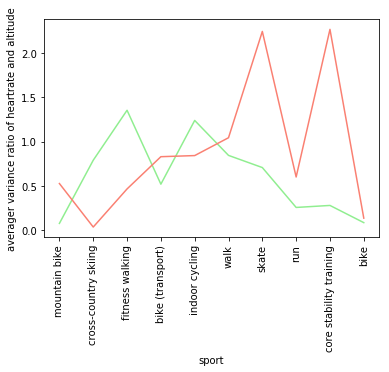

In [284]:
rdd4AInner=df4AInner.rdd
sportType=rdd4AInner.map(lambda row: row['sport']).collect()
ratioMVarhtat=rdd4AInner.map(lambda row: row['ratioMVarhtat']).collect()
ratioMVarhtsp=rdd4AInner.map(lambda row: row['ratioMVarhtsp']).collect()
ratioFMVarhtat=rdd4AInner.map(lambda row: row['ratioFMVarhtat']).collect()
ratioFMVarhtsp=rdd4AInner.map(lambda row: row['ratioFMVarhtsp']).collect()
plt.xticks(rotation=90)
plt.xlabel('sport')
plt.ylabel('averager variance ratio of heartrate and altitude')
plt.plot(sportType,ratioMVarhtat,color='lightgreen',label='ratioMVarhtat')
plt.plot(sportType,ratioFMVarhtat,color='salmon',label='ratioFMVarhtat')

Results: 1) Female and male donot show a similar trend. The average variance ratios of female and male present different trends as sport type changes  

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

Text(0.5, 0, 'sport')

Text(0, 0.5, 'averager variance ratio of heartrate and speed')

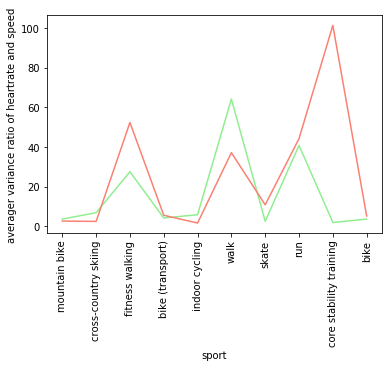

In [285]:
plt.xticks(rotation=90)
plt.xlabel('sport')
plt.ylabel('averager variance ratio of heartrate and speed')
plt.plot(sportType,ratioMVarhtsp,color='lightgreen',label='ratioMVarhtsp')
plt.plot(sportType,ratioFMVarhtsp,color='salmon',label='ratioFMVarhtsp')

Results: 1) Female and male show nearly similar trends. The average variance ratios of female and male present similar trends as sport type changes 